In [31]:
import os

print('JAVA_HOME' in os.environ)

True


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt 
from tqdm import tqdm 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

okt = Okt()

In [33]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x179d832f948>)

In [34]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [35]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [36]:
print('훈련용 리뷰 개수:',len(train_data))

훈련용 리뷰 개수: 150000


In [37]:
train_data['document'].nunique(), train_data['label'].nunique()
#unique는 고유한 값만 출력
#nunique는 고유한 값의 갯수 출력

(146182, 2)

In [38]:
train_data.drop_duplicates(subset=['document'], inplace=True)
#중복된 데이터 제거

In [39]:
print('훈련용 리뷰 개수:',len(train_data))

훈련용 리뷰 개수: 146183


<AxesSubplot:>

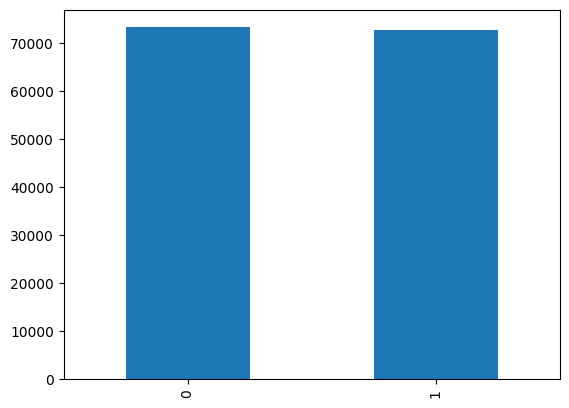

In [40]:
train_data['label'].value_counts().plot(kind = 'bar')

In [41]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [42]:
print(train_data.isnull().values.any())

True


In [43]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [44]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [45]:
train_data = train_data.dropna(how = 'any') #nan 값이 1개라도 있으면 삭제
print(train_data.isnull().values.any())

False


In [46]:
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))
# 특수문자 제거하는 정규표현식

do you expect people to read the FAQ etc and actually accept hard atheism


In [47]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]
#한글 특수문자 제거하는 정규표현식

c:\Project\AI_Source\AI_01\venv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [48]:
train_data['document'] = train_data['document'].str.replace('^ +', "")#첫번째 문자열을 빈문자열로 변경
train_data['document'].replace('', np.nan, inplace=True) #빈문자열을 nan으로 변경
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


c:\Project\AI_Source\AI_01\venv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [49]:
train_data.loc[train_data.document.isnull()][:5] #nan인 데이터 일부를 확인

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [50]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [51]:
#학습데이터에서 한 전처리를 test데이터에도 적용
test_data.drop_duplicates(subset = ['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


c:\Project\AI_Source\AI_01\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Project\AI_Source\AI_01\venv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [53]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
#조사,접미사 를 조사
#불용어: 분석에 큰 의미가 없는 단어

In [54]:
#형태소: 의미를 가지는 가장 작은 단위
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [60]:
#명사만 추출
okt.nouns('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['것', '영화', '차라리', '뮤직비디오', '게', '뻔']

In [62]:
X_train = []

#형태소중에 불용어가 포함되어있으면 제거
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [05:22<00:00, 450.43it/s]


In [63]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [64]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [01:54<00:00, 426.16it/s]


In [67]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

In [70]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [71]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기:',vocab_size)

단어 집합의 크기: 19416


In [72]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [73]:
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


In [75]:
y_train = np.array(train_data['label']) #레이블만 따로 추출
y_test = np.array(test_data['label'])

In [76]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [78]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


c:\Project\AI_Source\AI_01\venv\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


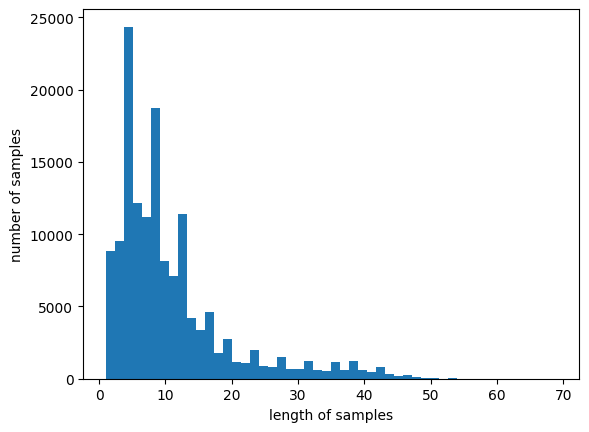

In [79]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [80]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [81]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [82]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [84]:
# EarlyStopping() : 검증셋에서 손실이 더이상 감소하지 않으면 중단.
#  - monitor : EarlyStopping 적용할지 여부를 결정할 때 기준이 되는 값 지정 
#              loss, val_loss, accuracy, val_accuracy등을 지정 
#             보통 Model.compile 메소드에 지정한 metrics과 관련된 것으로 지정한다. 
#  - min_delta : min_delta에서 지정한 값만큼 monitor에서 지정한 값이 변했어야 
#                mode에서 지정한 방향으로 값이 변한 것으로 간주하여 학습 중단 
#  - patience : monitor에 지정된 값이 patience에서 지정한 횟수만큼 epoch를 
#               진행했는데도 개선되지 않았다면 학습을 중단
#  - mode : monitor가 accuracy 또는 val_accuracy로 지정된 경우에는 max로 이전 값보다 커지는 경우에만 모델이 저장됩니다. 
#           monitor가 loss 또는 val_loss로 지정된 경우에는 min으로 이전 값보다 작아지는 경우에만 모델이 저장됩니다. 
#           auto의 경우에는 monitor에 지정된 것을 보고 알아서 판단하여 모델 저장.
#  - baseline : monitor에 지정된 값이 baseline에 지정된 값보다 개선되지 않으면  학습 중단

# ModelCheckpoint() : 검증셋에서 손실이 저 작아질때만 저장
#  - filepath ='best_model.h5' : 파일명 지정
#  - monitor='val_acc': 콜백함수에서 모델을 저장할때 기준이 되는 값을 지정. 
#                  loss, val_loss, accuracy, val_accuracy등을 지정할 수 있다. 
#  - mode : monitor가 accuracy 또는 val_accuracy로 지정된 경우에는 max로 이전 값보다 커지는 경우에만 모델이 저장됩니다. 
#           monitor가 loss 또는 val_loss로 지정된 경우에는 min으로 이전 값보다 작아지는 경우에만 모델이 저장됩니다. 
#           auto의 경우에는 monitor에 지정된 것을 보고 알아서 판단하여 모델 저장.  
#  - save_weights_only : Ture이면 모델 가중치만 저장되며 False이면 모델 전체 저장 
#  - save_best_only   Ture : 이전보다 성능이 좋은 경우에만 모델이 저장
#  - save_freq : 'epoch' 또는 정수를 사용. 디폴트 값은 'epoch'
#               문자열 'epoch'를 값으로 사용하면 각 epoch 끝날때 마다 모델 저장
#              정수를 값으로 사용하면 지정한 정수만큼의 배치를 사용한 후, 모델 저장

In [83]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(filepath='best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1814/1815 [============================>.] - ETA: 0s - loss: 0.3918 - acc: 0.8229WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000179D8343CA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

In [85]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1527/1527 [==============================] - 13s 8ms/step - loss: 0.3399 - acc: 0.8561

 테스트 정확도: 0.8561


In [9]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)
    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [87]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 494ms/step
93.54% 확률로 긍정 리뷰입니다.



In [88]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 [==============================] - 0s 24ms/step
74.97% 확률로 긍정 리뷰입니다.

